In [ ]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.shape

(7613, 5)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 120

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Bogus Disaster Tweet')

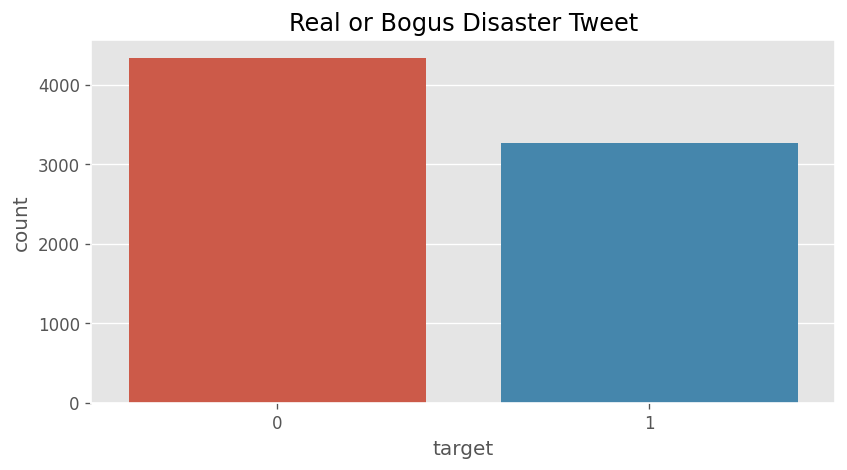

In [ ]:
sns.countplot('target', data=data)
plt.title('Real or Bogus Disaster Tweet')

In [ ]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
data[data['target'] == 1]['id']

0           1
1           4
2           5
3           6
4           7
        ...  
7608    10869
7609    10870
7610    10871
7611    10872
7612    10873
Name: id, Length: 3271, dtype: int64

In [ ]:
type(data['target'].value_counts())

pandas.core.series.Series

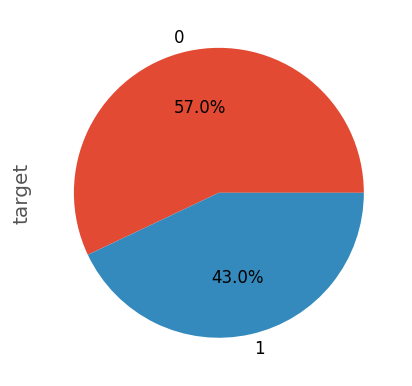

In [ ]:
data['target'].value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-9n7os3i1
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-9n7os3i1
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11743 sha256=64f21f5ce114db3b3429f3be63472d5a91e0b42bf4ff36d4f5a791deae73a8af
  Stored in directory: /tmp/pip-ephem-wheel-cache-nn9m_4r6/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as kgp

In [ ]:
data = kgp.get_basic_features(data)

In [ ]:
data.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


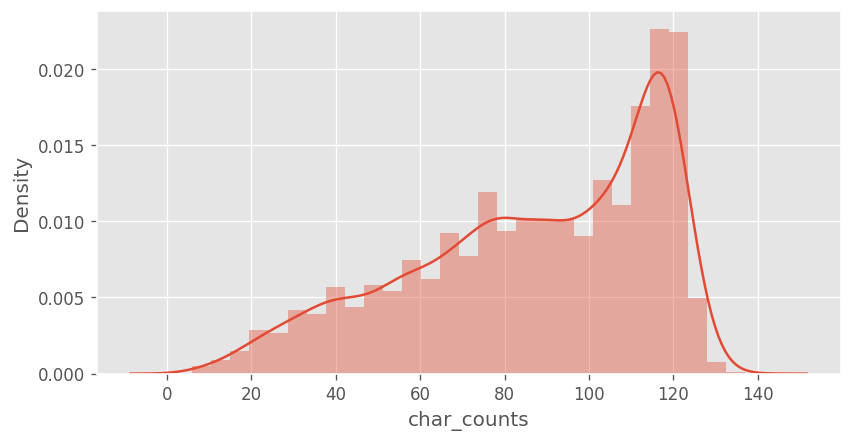

In [ ]:
sns.distplot(data['char_counts'])

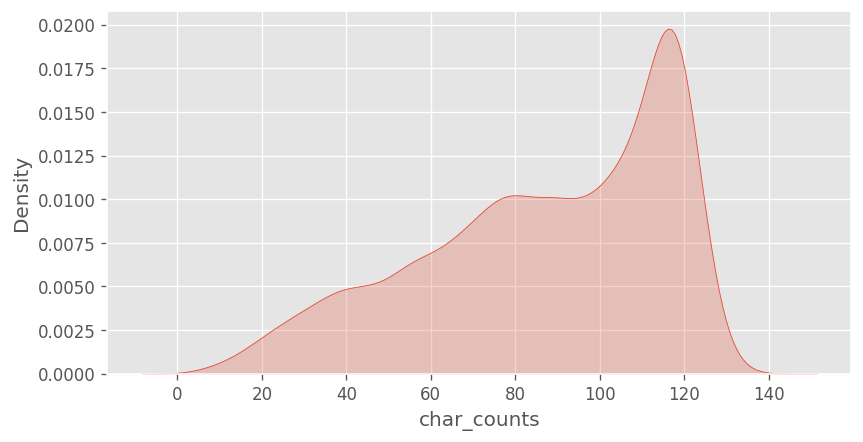

In [ ]:
sns.kdeplot(data['char_counts'], shade=True)

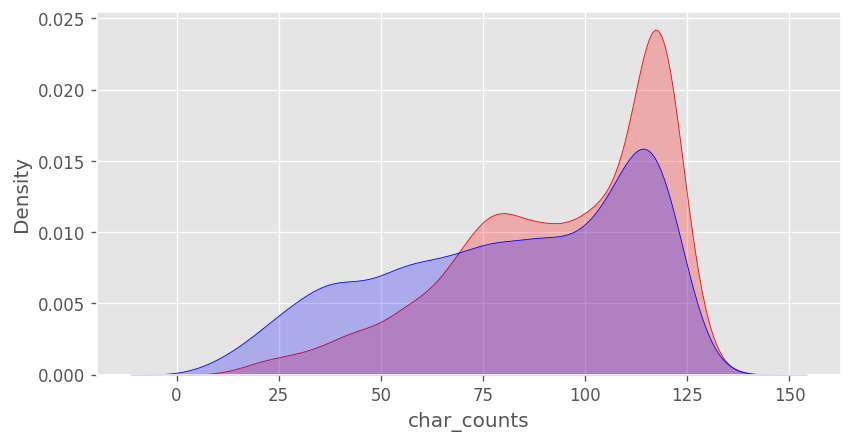

In [ ]:
sns.kdeplot(data[data['target']==1]['char_counts'], shade=True, color='red', label='Real Disaster')
sns.kdeplot(data[data['target']==0]['char_counts'], shade=True, color='blue', label='No Disaster')

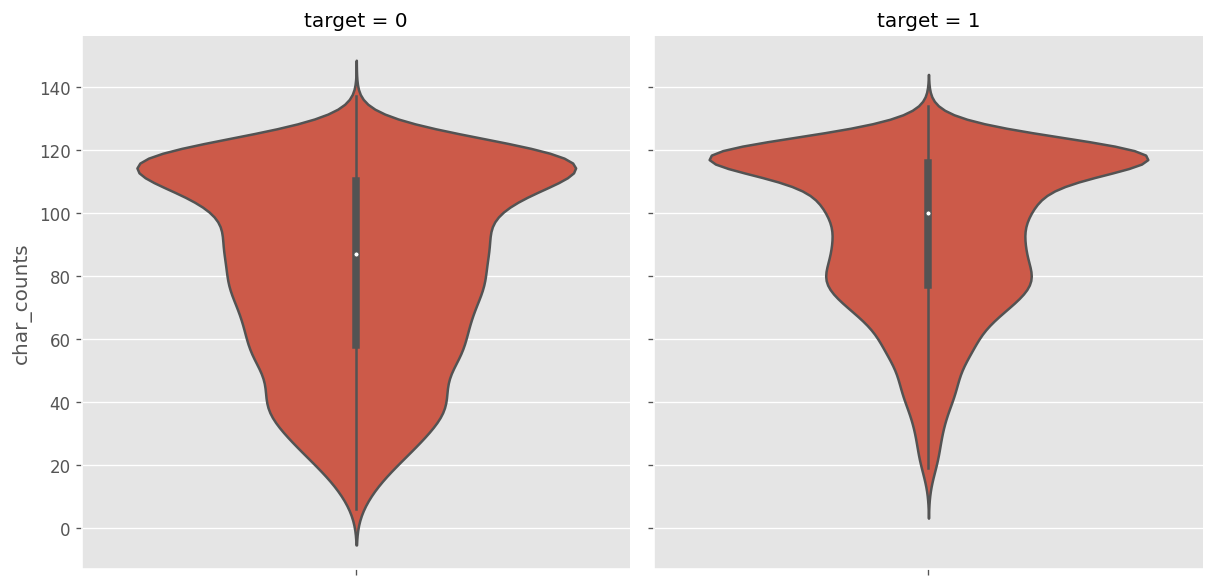

In [ ]:
sns.catplot(y='char_counts', data=data, kind='violin', col='target')

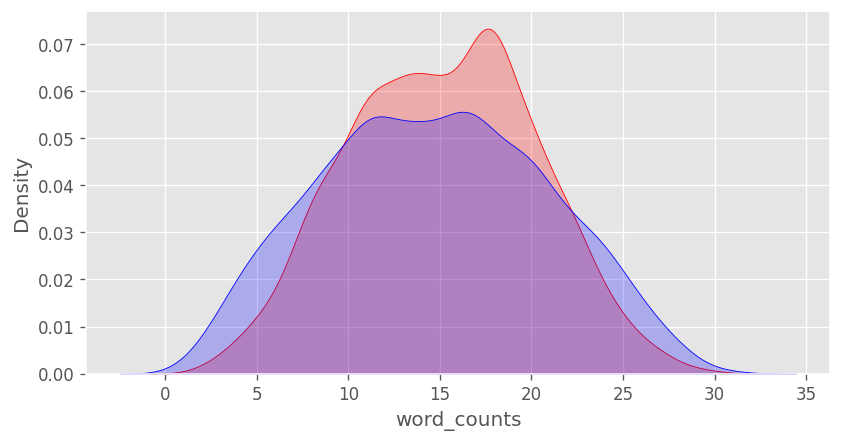

In [ ]:
sns.kdeplot(data[data['target']==1]['word_counts'], shade=True, color='red', label='Real Disaster')
sns.kdeplot(data[data['target']==0]['word_counts'], shade=True, color='blue', label='No Disaster')

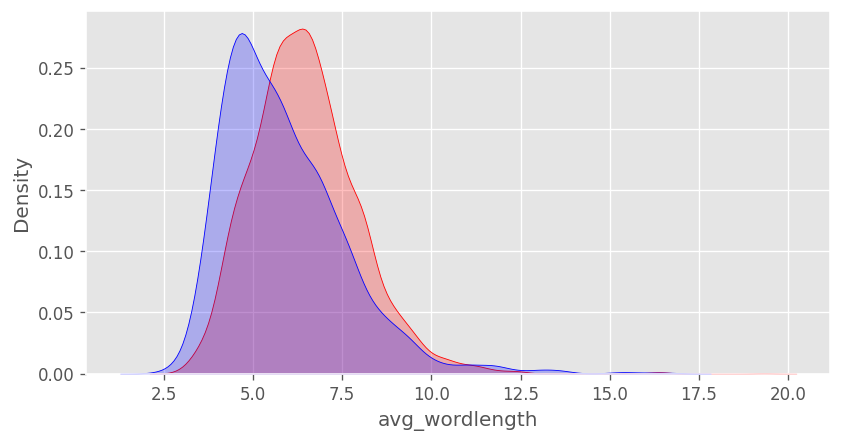

In [ ]:
sns.kdeplot(data[data['target']==1]['avg_wordlength'], shade=True, color='red', label='Real Disaster')
sns.kdeplot(data[data['target']==0]['avg_wordlength'], shade=True, color='blue', label='No Disaster')

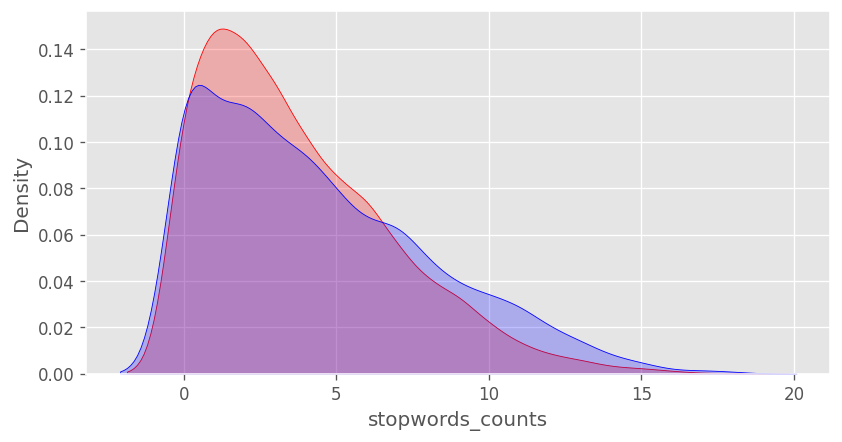

In [ ]:
sns.kdeplot(data[data['target']==1]['stopwords_counts'], shade=True, color='red', label='Real Disaster')
sns.kdeplot(data[data['target']==0]['stopwords_counts'], shade=True, color='blue', label='No Disaster')

In [ ]:
def get_value_counts(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

freqs = get_value_counts(data, 'text')

In [ ]:
freqs

the                       2575
a                         1845
to                        1805
in                        1757
of                        1722
                          ... 
Service!                     1
http://t.co/m2y9Ym3iF6       1
'great                       1
THINGS.                      1
http://t.co/98o2Kc3A1Z       1
Length: 31924, dtype: int64

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [ ]:
data['cleanText'] = data['text'].apply(lambda x: get_clean(x))

In [ ]:
data.head()['cleanText']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: cleanText, dtype: object

In [ ]:
real = kgp.get_word_freqs(data[data['target']==1], 'cleanText')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via disaster an were be people california suicide no has police who but when been killed like do 2 will just hiroshima than so fires out storm crash families we train now about into emergency s your buildings bomb there all two mh370 what they attack nuclear am video wildfire accident get one bombing new how prime northern burning minister legionnaires dead me bomber some homes if war car atomic still obama fatal he years off collapse may forest us retweet watch city debris japan malaysia today first 1 or mass latest man water near severe had those confirmed earthquake before would found oil down 70 spill floods world army warning home under injured outbreak 4 derailment weather 3 wreckage could evacuation 40 migrants saudi being thunderstorm our old during missing flooding say investigators can flood bridge their time state suspect back death her mosque cha

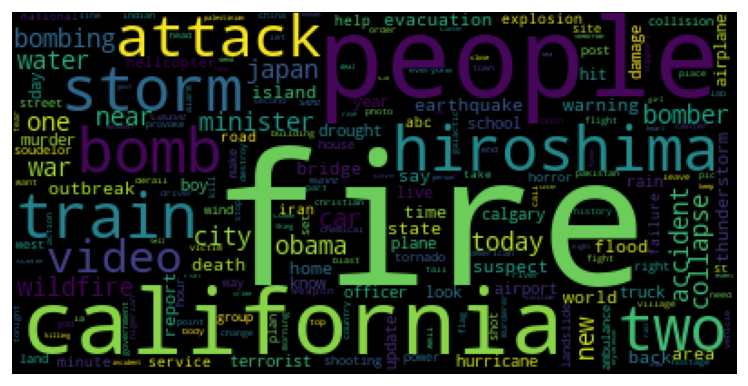

In [ ]:
# Real Disaster
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

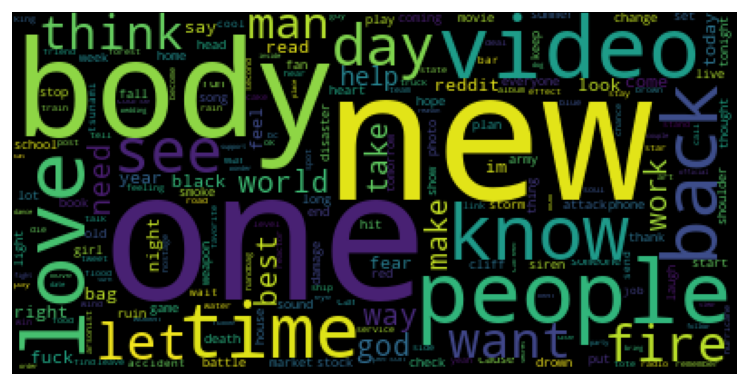

In [ ]:
# No Disaster
nreal = kgp.get_word_freqs(data[data['target']==0], 'cleanText')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
# Classification using TFIDF and SVM
text = data['cleanText']
y = data['target']

In [ ]:
text.shape

(7613,)

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [ ]:
data.cleanText[1]

'forest fire near la ronge sask canada'

In [ ]:
X.shape

(7613, 22545)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=115cdd89877e54dcb3044c1df6bad5007d724b986cffb90ff295c81e812a12ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-yj2kvnsf/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# Classification using Word2Vec and SVM
import spacy
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [ ]:
data['vec'] = data['text'].apply(lambda x: get_vec(x))

In [ ]:
data.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,cleanText,vec
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1,our deeds are the reason of this earthquake ma...,"[-0.27897874, 0.103925645, -0.09989621, -0.033..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0,forest fire near la ronge sask canada,"[-0.020768244, 0.053068247, -0.15192825, -0.27..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0,all residents asked to shelter in place are be...,"[-0.015307656, 0.06607368, -0.09196319, -0.087..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0,130 people receive wildfires evacuation orders...,"[-0.16429922, 0.2463819, 0.07442567, -0.197739..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0,just got sent this photo from ruby alaska as s...,"[-0.10624417, 0.06461317, 0.05314888, 0.088013..."


In [ ]:
type(data['vec'])

pandas.core.series.Series

In [ ]:
X = data['vec'].to_numpy()
X = X.reshape(-1, 1)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
X

array([[array([-2.78978735e-01,  1.03925645e-01, -9.98962075e-02, -3.32503617e-02,
        6.40578894e-03, -1.27987728e-01,  1.55760860e-02,  1.62035584e-01,
        1.98610928e-02,  2.14291310e+00, -1.20903090e-01, -5.62266000e-02,
        9.23507214e-02, -7.22638816e-02, -2.34850898e-01,  2.68438961e-02,
       -1.43910065e-01,  9.75105166e-01, -1.43673867e-01,  1.29929572e-01,
        1.65052172e-02, -1.22182645e-01, -2.26225760e-02,  9.07305703e-02,
        4.53584269e-02,  8.42299312e-02, -6.73524290e-02, -2.86993235e-02,
       -1.19723715e-01,  1.86341628e-01, -3.26146223e-02,  2.99569160e-01,
       -1.79654673e-01,  1.09754071e-01,  6.81390017e-02,  4.48725708e-02,
       -9.04034600e-02,  4.55693081e-02, -7.24119470e-02,  1.29921570e-01,
       -1.92646503e-01, -2.31275000e-02,  3.71478572e-02, -2.79082861e-02,
       -2.00716369e-02, -5.76707833e-02, -1.70356571e-03,  2.18306139e-01,
        2.12836470e-02,  6.24189302e-02, -7.78222829e-02,  2.06806902e-02,
       -1.3132777

In [ ]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [ ]:
X.shape

(7613, 300)

In [ ]:
y = data['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       869
           1       0.82      0.72      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

CPU times: user 3.57 s, sys: 36.9 ms, total: 3.61 s
Wall time: 3.6 s


# Classification with Word Embeddings and Deep Learning Model

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [ ]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: cleanText, Length: 7613, dtype: object

In [ ]:
token = Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [ ]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [ ]:
encoded_text = token.texts_to_sequences(text)

In [ ]:
encoded_text

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41],
 [186, 43, 223, 763, 6792, 6793, 1328],
 [41,
  1682,
  1435,
  5,
  2062,
  4,
  655,
  22,
  125,
  6794,
  19,
  1683,
  42,
  438,
  253,
  58,
  2062,
  4,
  655,
  1329,
  22,
  1054],
 [2809, 56, 4493, 1330, 253, 1329, 4, 86],
 [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189],
 [2810,
  391,
  86,
  1554,
  793,
  829,
  4,
  637,
  6797,
  534,
  5,
  1106,
  372,
  43,
  4494,
  1330],
 [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555],
 [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495],
 [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703],
 [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354],
 [586, 56, 611, 23, 2, 283, 467, 32, 612],
 [833,
  613,
  2811,
  9,
  217,
  2812,
  3467,
  656,
  3,
  657,
  7,
  199,
  4,
  613,
  2811,
  57,
  31,
  7,
  301,
  27,
  57,
  31,
  7,
  301,
  27,
  6799,
  247],
 [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 

In [ ]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [ ]:
X

array([[ 109, 4491,   22, ...,    0,    0,    0],
       [ 186,   43,  223, ...,    0,    0,    0],
       [  41, 1682, 1435, ...,    0,    0,    0],
       ...,
       [2709, 2295, 4483, ...,    0,    0,    0],
       [  75, 1092,   39, ...,    0,    0,    0],
       [   2,  206,   55, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X.shape

(7613, 40)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
# Classical models

clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.64      0.61       869
           1       0.44      0.37      0.40       654

    accuracy                           0.52      1523
   macro avg       0.51      0.51      0.50      1523
weighted avg       0.52      0.52      0.52      1523



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 7s 29ms/step - loss: 0.6770 - accuracy: 0.5845 - val_loss: 0.6019 - val_accuracy: 0.7485
Epoch 2/5
191/191 [==============================] - 5s 28ms/step - loss: 0.5084 - accuracy: 0.7666 - val_loss: 0.4948 - val_accuracy: 0.7807
Epoch 3/5
191/191 [==============================] - 5s 28ms/step - loss: 0.3572 - accuracy: 0.8528 - val_loss: 0.5115 - val_accuracy: 0.7446
Epoch 4/5
191/191 [==============================] - 5s 28ms/step - loss: 0.2344 - accuracy: 0.9171 - val_loss: 0.5287 - val_accuracy: 0.7656
Epoch 5/5
191/191 [==============================] - 5s 28ms/step - loss: 0.1683 - accuracy: 0.9410 - val_loss: 0.6287 - val_accuracy: 0.7328


In [ ]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [ ]:
x = 'There was fire in the jungle'
vec = get_encoded(x)

In [ ]:
model.predict(vec)

array([[0.7841835]], dtype=float32)

# Classification with BERT

In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 1.5MB/s 
     |████████████████████████████████| 6.8MB 47.5MB/s 
     |████████████████████████████████| 983kB 46.2MB/s 
     |████████████████████████████████| 266kB 52.2MB/s 
     |████████████████████████████████| 1.9MB 46.5MB/s 
     |████████████████████████████████| 1.2MB 46.3MB/s 
     |████████████████████████████████| 471kB 48.0MB/s 
     |████████████████████████████████| 3.3MB 31.1MB/s 
     |████████████████████████████████| 901kB 49.7MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=b062f4cd7c778ea827e7e288fc7560440fc0540c67300e202a6b826192b49f31
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=e822f8150a0df099ecbd28003e1460f0bfe84d9e03d536834f140b3b7caad236
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [ ]:
from ktrain import text
import ktrain

ImportError: ignored

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=data, 
                                                                   text_column='text', 
                                                                   label_columns='target', 
                                                                   maxlen=40, 
                                                                   preprocess_mode='bert')

In [ ]:
model = text.text_classifier(name='bert', 
                             train_data=(X_train, y_train), preproc=preproc)

In [ ]:
learner = ktrain.get_learner(model=model, 
                             train_data=(X_train, y_train), 
                             val_data=(X_test, y_test), 
                             batch_size=64)

In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs=1)

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [ ]:
predictor.predict(data, return_proba=True)

In [ ]:
classes = predictor.get_classes()

In [ ]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)